In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
import torch.nn.functional as F

from torch.autograd import Variable
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns

from tkmodel.TwoCUM_copy import TwoCUMfittingConc
from tkmodel.TwoCUM_copy import TwoCUM

In [3]:
from ml_model.data_generation import uterus


In [4]:
num = 100000
    
uterus_data = uterus(num)

In [5]:
y = uterus_data.y

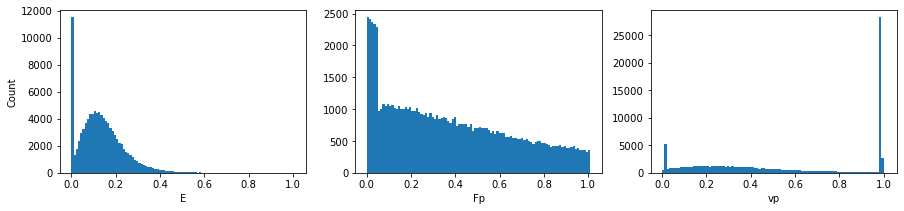

<Figure size 432x288 with 0 Axes>

In [6]:


E = y[:,0]
Fp = y[:,1]
vp = y[:,2]

fig, axs = plt.subplots(1, 3, figsize=(15, 3))

axs[0].hist(E,range=[0, 1.01], bins = 100)
axs[0].set_xlabel('E')
axs[0].set_ylabel('Count')


axs[1].hist(100*Fp,range=[0, 1.01], bins = 100)
axs[1].set_xlabel('Fp')


axs[2].hist(vp,range=[0, 1.01], bins = 100)
axs[2].set_xlabel('vp')


plt.show()
plt.clf()

In [7]:
def get_best_distribution(data):
    dist_names = ["norm", "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme", "halfnorm"]
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(st, dist_name)
        param = dist.fit(data)

        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = st.kstest(data, dist_name, args=param)
        print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))

    return best_dist, best_p, params[best_dist]

In [8]:
real_x = uterus_data.real_x
real_y = uterus_data.real_y
real_x.shape, real_y.shape

((42599, 150), (42599, 3))

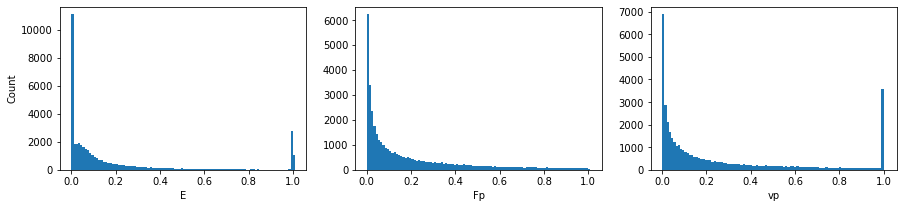

<Figure size 432x288 with 0 Axes>

In [9]:


E = real_y[:,0]
Fp = real_y[:,1]
vp = real_y[:,2]

fig, axs = plt.subplots(1, 3, figsize=(15, 3))

axs[0].hist(E,range=[0, 1.01], bins = 100)
axs[0].set_xlabel('E')
axs[0].set_ylabel('Count')


axs[1].hist(100*Fp,range=[0, 1.01], bins = 100)
axs[1].set_xlabel('Fp')


axs[2].hist(vp,range=[0, 1.01], bins = 100)
axs[2].set_xlabel('vp')


plt.show()
plt.clf()

# Find new dist for E

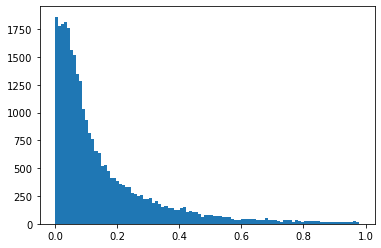

In [10]:
E_list = real_y[:,0]
E_restricted = E_list[(E_list > 0.00001) & (E_list < 0.98)]

plt.hist(E_restricted, bins = 100)
plt.show()

In [11]:


best_dist, best_p, params = get_best_distribution(E_restricted)

p value for norm = 0.0
p value for exponweib = 2.282239779129942e-12
p value for weibull_max = 0.0
p value for weibull_min = 1.3137373629612729e-38


/usr/lib/python3/dist-packages/scipy/stats/_distn_infrastructure.py:2381: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


p value for pareto = 6.553737875277351e-19
p value for genextreme = 2.1278022003165033e-30
p value for halfnorm = 0.0
Best fitting distribution: exponweib
Best p value: 2.282239779129942e-12
Parameters for the best fit: (1.7162775627078726, 0.6992052384902265, 7.607697024682173e-06, 0.08199239222931205)


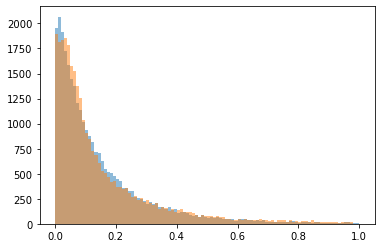

In [12]:
params = (1.7162775627078726, 0.6992052384902265, 7.607697024682173e-06, 0.08199239222931205)
dist_num = E_restricted.shape[0]
gen_data_E = st.exponweib.rvs(params[0], params[1], params[2], params[3], size=dist_num)

plt.hist(gen_data_E, bins = 100, range=[0, 1], alpha = 0.5)
plt.hist(E_restricted, bins = 100, range=[0, 1], alpha = 0.5)

plt.show()

In [13]:
#find percentage values at the edges
size = E_list.shape[0]

start = E_list[(E_list < 0.00001)]
end = E_list[(E_list > 0.99)]

start_percent = start.shape[0]/size
end_percent = end.shape[0]/size

start_percent, end_percent

(0.21577971313880606, 0.08969694124275218)

In [14]:
def E_distribution(num):
    start_percent, end_percent = 0.2157, 0.089
    params = (1.7162775627078726, 0.6992052384902265, 7.607697024682173e-06, 0.08199239222931205)
    start_nums = int(start_percent*num)
    end_nums = int(end_percent*num)
    
    start = np.random.uniform(low = 0, high= 0.00001, size = start_nums)
    end = np.random.uniform(low = 0.99, high= 1, size = end_nums)
    
    dist_num = num - start_nums - end_nums
    gen_data_E = st.exponweib.rvs(params[0], params[1], params[2], params[3], size=dist_num)
    gen_data_E = np.array(gen_data_E)
    
    true_dist = np.concatenate((start, gen_data_E), axis=None)
    true_dist = np.concatenate((true_dist, end), axis=None)

    return true_dist

(42599,) (42599,)


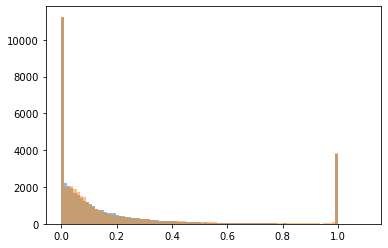

In [15]:
gen_data_E = E_distribution(E_list.shape[0])
print(gen_data_E.shape, E_list.shape)

plt.hist(gen_data_E, bins = 100, range=[0, 1.1], alpha = 0.5)
plt.hist(E_list, bins = 100, range=[0, 1.1], alpha = 0.5)

plt.show()

# Find Fp


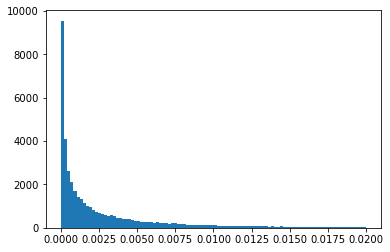

In [37]:
Fp_list = real_y[:,1]
#Fp_list_res = Fp_list[(Fp_list > 0.00001) & (Fp_list < 0.98)]

plt.hist(Fp_list, bins = 100, range = [0,0.02])
plt.show()

In [38]:
best_dist, best_p, params = get_best_distribution(Fp_list)

p value for norm = 0.0


/usr/lib/python3/dist-packages/scipy/stats/_continuous_distns.py:1468: RuntimeWarning: invalid value encountered in add
  logp = (np.log(a) + np.log(c) + sc.xlogy(a - 1.0, exm1c) +


p value for exponweib = 2.0899460903837002e-07
p value for weibull_max = 0.0
p value for weibull_min = 0.0


/usr/lib/python3/dist-packages/scipy/stats/_distn_infrastructure.py:2381: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


p value for pareto = 0.0
p value for genextreme = 1.8217304726719606e-271
p value for halfnorm = 0.0
Best fitting distribution: exponweib
Best p value: 2.0899460903837002e-07
Parameters for the best fit: (1.222754777103586, 0.49935926672960007, 3.0005798742817294e-05, 0.001543309761969799)


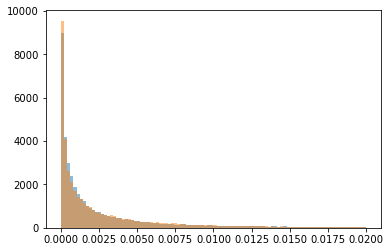

In [39]:
params = (1.222754777103586, 0.49935926672960007, 3.0005798742817294e-05, 0.001543309761969799)
dist_num = Fp_list.shape[0]
gen_Fp_list = st.exponweib.rvs(params[0], params[1], params[2], params[3], size=dist_num)

plt.hist(gen_Fp_list, bins = 100, range=[0, 0.02], alpha = 0.5)
plt.hist(Fp_list, bins = 100, range=[0, 0.02], alpha = 0.5)

plt.show()

In [40]:
def Fp_distribution(num):

    params = (1.7162775627078726, 0.6992052384902265, 7.607697024682173e-06, 0.08199239222931205)

    gen_Fp_list = st.exponweib.rvs(params[0], params[1], params[2], params[3], size=dist_num)
    true_dist = np.array(gen_Fp_list)
    
    return true_dist

# find vp

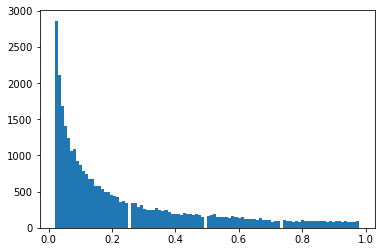

In [62]:
#weird discontinieties 
vp_list = real_y[:,2]
vp_list_res = vp_list[(vp_list > 0.01) & (vp_list < 0.99)]

plt.hist(vp_list_res, bins = 100 )
plt.show()

In [59]:
best_dist, best_p, params = get_best_distribution(vp_list_res)

p value for norm = 0.0
p value for exponweib = 0.0
p value for weibull_max = 0.0
p value for weibull_min = 0.0
p value for pareto = 4.6618397563659426e-222
p value for genextreme = 1.386425253018638e-149
p value for halfnorm = 0.0
Best fitting distribution: genextreme
Best p value: 1.386425253018638e-149
Parameters for the best fit: (-0.8957657375828095, 0.08444687209554147, 0.08782456984037149)


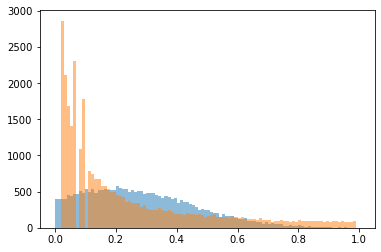

In [60]:
params = (0.20250845633456332, 0.24013607142736623)
dist_num = vp_list_res.shape[0]
gen_vp_list = st.norm.rvs(params[0], params[1], size=dist_num)

plt.hist(gen_vp_list, bins = 100, range=[0, 1], alpha = 0.5)
plt.hist(vp_list_res, bins = 100, range=[0, 1], alpha = 0.5)

plt.show()

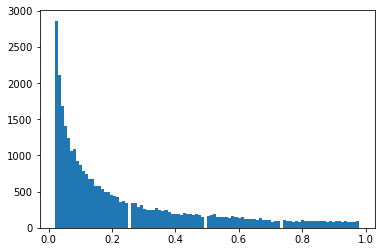

[2864. 2117. 1689. 1412. 1242. 1061. 1083.  919.  862.  782.  742.  670.
  669.  581.  575.  540.  498.  497.  454.  434.  424.  362.  374.  349.
    0.  343.  347.  287.  316.  255.  250.  247.  244.  271.  250.  229.
  245.  221.  192.  193.  189.  179.  198.  188.  187.  178.  194.  176.
  149.    0.  166.  171.  184.  152.  150.  144.  153.  140.  162.  150.
  136.  147.  116.  128.  124.  115.  114.  132.  106.  109.  110.   87.
   95.   96.    0.  105.   96.   93.   87.   95.   80.  106.   92.   91.
   94.   88.   91.   91.   93.   80.   88.   80.   93.   90.   74.   93.
   76.   81.   85.   89.]
[2864.  2117.  1689.  1412.  1242.  1061.  1083.   919.   862.   782.
  742.   670.   669.   581.   575.   540.   498.   497.   454.   434.
  424.   362.   374.   349.   346.   343.   347.   287.   316.   255.
  250.   247.   244.   271.   250.   229.   245.   221.   192.   193.
  189.   179.   198.   188.   187.   178.   194.   176.   149.   157.5
  166.   171.   184.   152.   150.   14

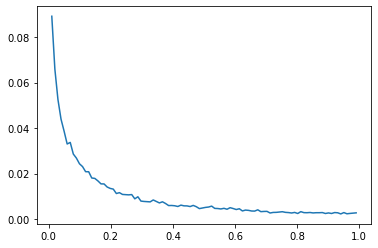

<Figure size 432x288 with 0 Axes>

In [121]:
vp_list_res = vp_list[(vp_list > 0.01) &(vp_list < 0.99)]
counts, edges, plot = plt.hist(vp_list_res, bins = 100 )
plt.show()
plt.clf()
print(counts)
counts = np.array(counts)
for i, count in enumerate(counts):
    if count == 0:
        counts[i] = (counts[i-1] + counts[i+1])/2
        
print(counts)
print(vp_list_res.shape[0])
prob_plot = counts/vp_list_res.shape[0]
x = np.linspace( 0.01,0.99, num =prob_plot.shape[0])
plt.plot(x, prob_plot)
plt.show()
plt.clf()

In [122]:
vp_hist_list = []
while len(vp_hist_list) < vp_list_res.shape[0]:
    x_val = np.random.uniform( low = 0.01, high= 0.99, size=1)
    y_val = np.interp(x_val, x ,prob_plot)
    prob = np.random.uniform(size=1)
    if prob < y_val:
        vp_hist_list.append(x_val)



In [123]:
vp_hist_list = np.array(vp_hist_list)


In [124]:
new_vp = vp_hist_list.reshape(vp_hist_list.shape[0])
new_vp.shape

(32146,)

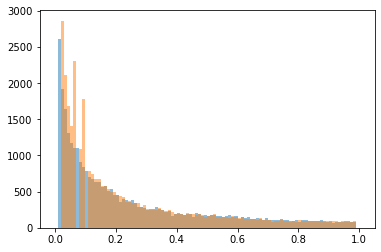

In [125]:
plt.hist(new_vp, bins= 100, alpha = 0.5, range = [0,1])
plt.hist(vp_list_res, bins = 100, alpha = 0.5,  range = [0,1])
plt.show()

In [126]:
best_dist, best_p, params = get_best_distribution(new_vp)

p value for norm = 0.0
p value for exponweib = 3.5967225479750384e-34
p value for weibull_max = 0.0
p value for weibull_min = 3.425622387640762e-42
p value for pareto = 1.0249853067477964e-102
p value for genextreme = 6.654474118306384e-136
p value for halfnorm = 0.0
Best fitting distribution: exponweib
Best p value: 3.5967225479750384e-34
Parameters for the best fit: (0.501198003887801, 1.3306579742427025, 0.010005660986937497, 0.395689314967677)


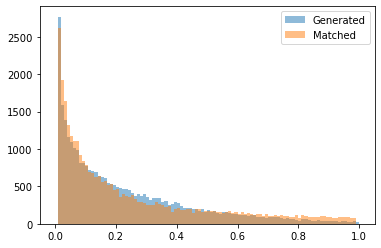

In [128]:
params = (0.501198003887801, 1.3306579742427025, 0.010005660986937497, 0.395689314967677)
dist_num = new_vp.shape[0]
gen_vp_list = st.exponweib.rvs(params[0], params[1], params[2], params[3], size=dist_num)

plt.hist(gen_vp_list, bins = 100, range=[0, 1], alpha = 0.5, label = 'Generated')
plt.hist(new_vp, bins = 100, range=[0, 1], alpha = 0.5, label = 'Matched')
#plt.hist(vp_list_res, bins = 100, range=[0, 1], alpha = 0.5, label = 'True')
plt.legend()

plt.show()

In [132]:
vp_start = vp_list[(vp_list <= 0.01) ]
vp_end = vp_list[(vp_list >= 0.99)]

start_percent = vp_start.shape[0]/vp_list.shape[0]
end_percent = vp_end.shape[0]/vp_list.shape[0]

start_percent, end_percent

(0.16145918918284466, 0.08392215779713139)

In [148]:
def vp_distribution(num):
    start_percent, end_percent = 0.16145, 0.0839
    params = (0.501198003887801, 1.3306579742427025, 0.010005660986937497, 0.395689314967677)
    start_nums = int(start_percent*num)
    end_nums = int(end_percent*num)
    
    start = np.random.uniform(low = 0, high= 0.01, size = start_nums)
    end = np.random.uniform(low = 0.98, high= 0.99, size = end_nums)
    
    dist_num = num - start_nums - end_nums
    gen_data_vp = st.exponweib.rvs(params[0], params[1], params[2], params[3], size=dist_num)
    gen_data_vp = np.array(gen_data_vp)
    
    true_dist = np.concatenate((start, gen_data_vp), axis=None)
    true_dist = np.concatenate((true_dist, end), axis=None)

    return true_dist

(42599,) (42599,)


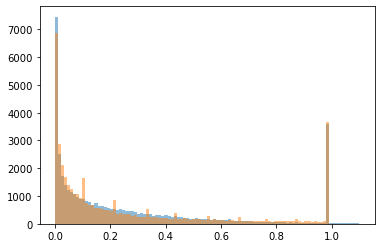

In [149]:
gen_data_vp = vp_distribution(vp_list.shape[0])
print(gen_data_vp.shape, vp_list.shape)

plt.hist(gen_data_vp, bins = 100, range=[0, 1.1], alpha = 0.5, label = 'Generated')
plt.hist(vp_list, bins = 100, range=[0, 1.1], alpha = 0.5, label = 'True')

plt.show()